# Importing Required Libraries

In [1]:
import librosa
from glob import glob
import numpy as np
from sklearn.mixture import GaussianMixture
import math
import sklearn.metrics

# Set path and parameters

In [2]:
base_path=r"C:\Users\Asus\Documents\GitHub\Speaker_Verification\IITGMV"
model_save_path=r"C:\Users\Asus\Documents\GitHub\Speaker_Verification\Save path\\"
train_path= base_path + '\\' + 'Train_Folder'
test_path=  base_path + '\\' + 'Test_Folder'

In [3]:
cl_sz=64

In [4]:
train_files_1 = glob(train_path+"\*\*_AH01OENC.wav")
train_files_2 = glob(train_path+"\*\*_AH01MENC.wav")
train_files = train_files_1 + train_files_2
train_files.sort()

In [5]:
test_files_1 = glob(test_path+"\*\*_AH01OENC*")
test_files_2 = glob(test_path+"\*\*_AH01MENC*")
test_files = test_files_1 + test_files_2
test_files.sort()

In [6]:
len(train_files)

70

In [7]:
len(test_files)

1048

# Extract Features and Train GMM

In [8]:
GMMSPK =[]
for i in range(len(train_files)):
 audio_data, fs = librosa.load(train_files[i],sr=8000)

 audio_data=audio_data-np.mean(audio_data)
 audio_data=audio_data/(1.01*(max(abs(audio_data))))

 MFCC    = librosa.feature.mfcc(y=audio_data,sr=fs, n_mfcc=14, lifter=1,dct_type=3,hop_length=int(0.01*fs), win_length=int(0.02*fs),window='hann', n_mels=24)
 MFCC_d  = librosa.feature.delta(MFCC, order=1)
 MFCC_dd = librosa.feature.delta(MFCC, order=2)

 MFCC=MFCC.T
 MFCC_d=MFCC_d.T
 MFCC_dd=MFCC_dd.T

 MFCC=MFCC[:,1:14]
 MFCC_d=MFCC_d[:,1:14]
 MFCC_dd=MFCC_dd[:,1:14]

 X = np.concatenate((MFCC, MFCC_d), axis=1)
 X = np.concatenate((X, MFCC_dd), axis=1)

 gmm=GaussianMixture(n_components=cl_sz, random_state=0, max_iter=100,covariance_type='diag').fit(X)
 GMMSPK.append(gmm)

 print('Training for SPK ',i,' completed')

Training for SPK  0  completed
Training for SPK  1  completed
Training for SPK  2  completed
Training for SPK  3  completed
Training for SPK  4  completed
Training for SPK  5  completed
Training for SPK  6  completed
Training for SPK  7  completed
Training for SPK  8  completed
Training for SPK  9  completed
Training for SPK  10  completed
Training for SPK  11  completed
Training for SPK  12  completed
Training for SPK  13  completed
Training for SPK  14  completed
Training for SPK  15  completed
Training for SPK  16  completed
Training for SPK  17  completed
Training for SPK  18  completed
Training for SPK  19  completed
Training for SPK  20  completed
Training for SPK  21  completed
Training for SPK  22  completed
Training for SPK  23  completed
Training for SPK  24  completed
Training for SPK  25  completed
Training for SPK  26  completed
Training for SPK  27  completed
Training for SPK  28  completed
Training for SPK  29  completed
Training for SPK  30  completed
Training for SPK  

## Save Models

In [9]:
from sklearn import mixture

for i in range(len(train_files)):
 gmm_name = 'Speaker_'+str(i)
 np.save(model_save_path+gmm_name+'_weights', GMMSPK[i].weights_, allow_pickle=False)
 np.save(model_save_path+gmm_name + '_means', GMMSPK[i].means_, allow_pickle=False)
 np.save(model_save_path+gmm_name + '_covariances', GMMSPK[i].covariances_, allow_pickle=False)
 np.save(model_save_path+gmm_name + '_precisions_cholesky', GMMSPK[i].precisions_cholesky_, allow_pickle=False)

# Test the Models

In [12]:
true = []
for i in range(len(test_files)):
  true.append(test_files[i].split('\\')[7])
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
true = le.fit_transform(true)

In [14]:
Score = []
speaker=[]
pred = []
prob=[]
for i in range(len(test_files)):
 audio_data, fs = librosa.load(test_files[i],sr=8000)

 audio_data=audio_data-np.mean(audio_data)
 audio_data=audio_data/(1.01*(max(abs(audio_data))))

 MFCC=librosa.feature.mfcc(y=audio_data,sr=fs, n_mfcc=14, lifter=1,dct_type=3,hop_length=int(0.01*fs), win_length=int(0.02*fs),window='hann', n_mels=24)
 MFCC_d  = librosa.feature.delta(MFCC, order=1)
 MFCC_dd = librosa.feature.delta(MFCC, order=2)

 MFCC=MFCC.T
 MFCC_d=MFCC_d.T
 MFCC_dd=MFCC_dd.T

 MFCC=MFCC[:,1:14]
 MFCC_d=MFCC_d[:,1:14]
 MFCC_dd=MFCC_dd[:,1:14]

 X = np.concatenate((MFCC, MFCC_d), axis=1)
 X = np.concatenate((X, MFCC_dd), axis=1)

 for j in range(0,70):#len(GMMSPK)):
  gmm_name = "Speaker_"+str(j)
  loaded_gmm = mixture.GaussianMixture(n_components = cl_sz, covariance_type='diag')
  means = np.load(model_save_path+gmm_name + '_means.npy')
  covar = np.load(model_save_path+gmm_name + '_covariances.npy')
  loaded_gmm.weights_ = np.load(model_save_path+gmm_name + '_weights.npy')
  loaded_gmm.precisions_cholesky_ = np.load(model_save_path+gmm_name + '_precisions_cholesky.npy')
  loaded_gmm.means_ = means
  loaded_gmm.covariances_ = covar
  log_likelihood = loaded_gmm.score(X)
  Score.append(log_likelihood)
 pred_label = np.argmax(Score)
 if(pred_label == true[i]):
   pred.append(1)
 else:
   pred.append(0)  
 prob.append(abs(max(Score)))  
 speaker.append(pred_label)
 Score=[]
 print("Testing of Utterence "+str(i)+" completed")

Testing of Utterence 0 completed
Testing of Utterence 1 completed
Testing of Utterence 2 completed
Testing of Utterence 3 completed
Testing of Utterence 4 completed
Testing of Utterence 5 completed
Testing of Utterence 6 completed
Testing of Utterence 7 completed
Testing of Utterence 8 completed
Testing of Utterence 9 completed
Testing of Utterence 10 completed
Testing of Utterence 11 completed
Testing of Utterence 12 completed
Testing of Utterence 13 completed
Testing of Utterence 14 completed
Testing of Utterence 15 completed
Testing of Utterence 16 completed
Testing of Utterence 17 completed
Testing of Utterence 18 completed
Testing of Utterence 19 completed
Testing of Utterence 20 completed
Testing of Utterence 21 completed
Testing of Utterence 22 completed
Testing of Utterence 23 completed
Testing of Utterence 24 completed
Testing of Utterence 25 completed
Testing of Utterence 26 completed
Testing of Utterence 27 completed
Testing of Utterence 28 completed
Testing of Utterence 29 

# Show the results

In [15]:
def compute_eer(label, pred, positive_label=1):

    fpr, tpr, threshold = sklearn.metrics.roc_curve(label, pred)
    fnr = 1 - tpr

    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

    eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    eer = (eer_1 + eer_2) / 2
    return eer

In [16]:
eer = compute_eer(pred, prob)
print('The equal error rate is {:.3f}'.format(eer))

The equal error rate is 0.486


In [17]:
from sklearn.metrics import accuracy_score
print("The Accuracy is ", accuracy_score(true, speaker))

The Accuracy is  0.9780534351145038


In [18]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(true, speaker)
print(CM)

[[18  0  0 ...  0  0  0]
 [ 0 11  0 ...  0  0  0]
 [ 0  0 14 ...  0  0  0]
 ...
 [ 0  0  0 ...  4  0  0]
 [ 0  0  0 ...  0  5  0]
 [ 0  0  0 ...  0  0  5]]


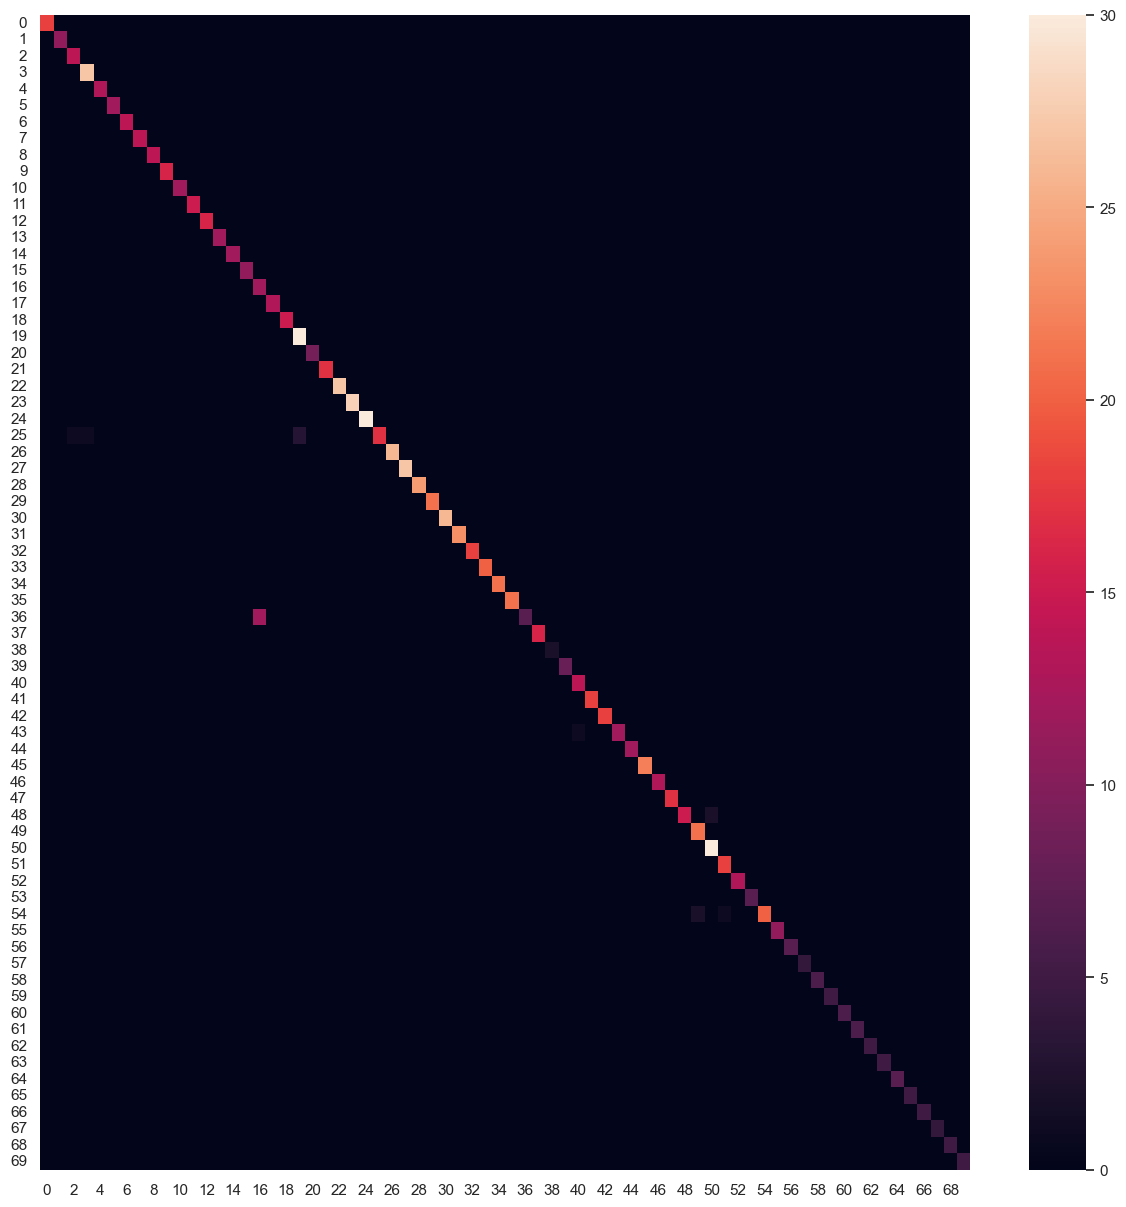

In [19]:
import seaborn as sn
import matplotlib.pyplot as plt
sn.set(rc = {'figure.figsize':(15,15)})
hm = sn.heatmap(data =CM)
plt.show()